In [1]:
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import librosa
import librosa.display
#import seaborn as sns

import cupy as cp

from glob import glob
import os
from sklearn.utils import shuffle
from numba import cuda 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
audio_files_path = fr'E:\Downloads\audio-dataset'
df = pd.read_csv(audio_files_path + '\esc50.csv')
df = df.drop(['fold', 'esc10', 'src_file', 'take'], axis = 1)
df

,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,14,chirping_birds
2,1-100210-A-36.wav,36,vacuum_cleaner
3,1-100210-B-36.wav,36,vacuum_cleaner
4,1-101296-A-19.wav,19,thunderstorm
...,...,...,...
1995,5-263831-B-6.wav,6,hen
1996,5-263902-A-36.wav,36,vacuum_cleaner
1997,5-51149-A-25.wav,25,footsteps
1998,5-61635-A-8.wav,8,sheep


In [3]:
audio_files = np.array(glob(audio_files_path + '\*\*.wav'))
audio_files.shape

(2000,)

In [4]:
def to_spectogram(y_tuple) :
    D = librosa.stft(y_tuple[0])
    S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)  #sound in decibel
    return S_db

def to_mel_spectogram(y_tuple) :
    S = librosa.feature.melspectrogram(y = y_tuple[0], sr = y_tuple[1], n_mels=128)
    return S

def to_mfcc(y_tuple) :
    mfccs_features = librosa.feature.mfcc(y = y_tuple[0], sr = y_tuple[1], n_mfcc=128)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#     return mfccs_features
    return mfccs_scaled_features

def get_data(start = 0, stop = 11) :
    audio_files_df = pd.DataFrame(audio_files, columns=['full_path'])
    audio_files_df['filename'] = audio_files_df.iloc[:, 0].map(lambda x : os.path.basename(x))
    
    new_df = audio_files_df.merge(df).iloc[start:stop] 
    del audio_files_df
        
    new_df['raw_data_sr'] = new_df.loc[:, 'full_path'].map(lambda x : librosa.load(x))
#     new_df['spectrogram'] = new_df.loc[:, 'raw_data_sr'].map(to_spectogram)
#     new_df['mel_spectrogram'] = new_df.loc[:, 'raw_data_sr'].map(to_mel_spectogram)
    new_df['mfcc_scaled'] = new_df.loc[:, 'raw_data_sr'].map(to_mfcc)

    X = np.stack(new_df['mfcc_scaled'].values)
    print(X)
    X = (X - X.mean()) / X.std()
    #T = pd.Categorical(new_df['category']).codes
    T = new_df.loc[:, 'target'].values.astype(np.int16)
    del new_df
    return X, T

def release_mem() :
    device = cuda.get_current_device()
    device.reset()

In [5]:
Xorig = np.load('Xorig.npy')
Torig = np.load('Torig.npy')

In [16]:
Xorig, Torig = get_data(0, 2000)

[[-6.0109698e+02  4.9158282e+00 -8.7268047e+00 ...  4.2269476e-02
  -1.2121227e-02  3.4730271e-02]
 [-1.9649599e+02  6.3035016e+00 -6.2931282e+01 ...  1.5449895e-01
  -8.0165707e-02  8.5282095e-02]
 [ 1.2359730e+01  6.2431587e+01 -1.4457329e+01 ...  4.0643170e-01
  -1.2845746e-01  5.7990426e-01]
 ...
 [-2.8908960e+02  8.4523781e+01  8.0870180e+00 ... -4.0449437e-02
  -1.5515727e-01 -1.7345512e-01]
 [-1.5004889e+02  9.7708214e+01 -4.0430267e+01 ...  5.6451374e-01
   4.7682995e-01 -1.9385140e-01]
 [-4.9152194e+02  5.9743629e+00 -3.0747921e+01 ...  1.8151146e-01
   2.4784334e-01  2.8620649e-02]]


In [17]:
np.save('Xorig', Xorig)
np.save('Torig', Torig)

In [6]:
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
tf.debugging.set_log_device_placement(False)
tf.get_logger().setLevel('INFO')

### Getting the transformed data

In [7]:
# release_mem()
Xorig, Torig = shuffle(Xorig, Torig)

In [8]:
Xorig.shape

(2000, 128)

In [90]:
# release_mem()
with tf.device('/cpu:0'):
    model=Sequential()
    ###1st layer
    model.add(Dense(512 ,input_shape=(Xorig.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    ###2nd layer
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    ###final layer
    model.add(Dense(50))
    model.add(Activation('softmax'))

In [91]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 512)               66048     
                                                                 
 activation_51 (Activation)  (None, 512)               0         
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                                 
 dense_52 (Dense)            (None, 128)               65664     
                                                                 
 activation_52 (Activation)  (None, 128)               0         
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 64)              

### Compile the Model

In [92]:
opt = SGD(learning_rate=0.01)
optimizer_adam = keras.optimizers.Adam(learning_rate=0.001) 

model.compile(optimizer=optimizer_adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the Model

In [93]:
X_test, T_test = Xorig[1900:], Torig[1900:]

# Run inference on CPU
with tf.device('/cpu:0'):
    Xtrain, Ttrain = tf.convert_to_tensor(Xorig[:1900]), tf.convert_to_tensor(Torig[:1900])
    
# # Run training on GPU
# with tf.device('/gpu:0'):

checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                           verbose=3, save_best_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

batch_size = 100
steps_per_epoch = Xtrain.shape[0] // batch_size
history = model.fit(Xtrain, Ttrain, 
          epochs=500, 
          validation_data=(X_test, T_test), 
#               steps_per_epoch=steps_per_epoch, 
#               batch_size = batch_size,
          callbacks=[checkpointer]) 

Epoch 1/500
56/60 [===========================>..] - ETA: 0s - loss: 3.9989 - accuracy: 0.0212
Epoch 1: val_loss improved from inf to 3.89627, saving model to .\audio_classification.hdf5
60/60 [==============================] - 1s 12ms/step - loss: 3.9946 - accuracy: 0.0205 - val_loss: 3.8963 - val_accuracy: 0.0300
Epoch 2/500
53/60 [=========================>....] - ETA: 0s - loss: 3.9019 - accuracy: 0.0259
Epoch 2: val_loss improved from 3.89627 to 3.86688, saving model to .\audio_classification.hdf5
60/60 [==============================] - 0s 6ms/step - loss: 3.9018 - accuracy: 0.0253 - val_loss: 3.8669 - val_accuracy: 0.0500
Epoch 3/500
52/60 [=========================>....] - ETA: 0s - loss: 3.8427 - accuracy: 0.0367
Epoch 3: val_loss improved from 3.86688 to 3.78050, saving model to .\audio_classification.hdf5
60/60 [==============================] - 0s 6ms/step - loss: 3.8403 - accuracy: 0.0379 - val_loss: 3.7805 - val_accuracy: 0.0200
Epoch 4/500
54/60 [========================

Epoch 27/500
60/60 [==============================] - ETA: 0s - loss: 2.6484 - accuracy: 0.2458
Epoch 27: val_loss did not improve from 2.73040
60/60 [==============================] - 0s 5ms/step - loss: 2.6484 - accuracy: 0.2458 - val_loss: 2.7561 - val_accuracy: 0.2200
Epoch 28/500
60/60 [==============================] - ETA: 0s - loss: 2.6274 - accuracy: 0.2453
Epoch 28: val_loss improved from 2.73040 to 2.70609, saving model to .\audio_classification.hdf5
60/60 [==============================] - 0s 6ms/step - loss: 2.6274 - accuracy: 0.2453 - val_loss: 2.7061 - val_accuracy: 0.2700
Epoch 29/500
57/60 [===========================>..] - ETA: 0s - loss: 2.6259 - accuracy: 0.2368
Epoch 29: val_loss did not improve from 2.70609
60/60 [==============================] - 0s 5ms/step - loss: 2.6273 - accuracy: 0.2384 - val_loss: 2.7169 - val_accuracy: 0.2600
Epoch 30/500
59/60 [============================>.] - ETA: 0s - loss: 2.6210 - accuracy: 0.2399
Epoch 30: val_loss did not improve f

60/60 [==============================] - 0s 6ms/step - loss: 2.1352 - accuracy: 0.3716 - val_loss: 2.4337 - val_accuracy: 0.3400
Epoch 55/500
60/60 [==============================] - ETA: 0s - loss: 2.1058 - accuracy: 0.3726
Epoch 55: val_loss improved from 2.43374 to 2.35395, saving model to .\audio_classification.hdf5
60/60 [==============================] - 0s 6ms/step - loss: 2.1058 - accuracy: 0.3726 - val_loss: 2.3540 - val_accuracy: 0.3500
Epoch 56/500
59/60 [============================>.] - ETA: 0s - loss: 2.1155 - accuracy: 0.3724
Epoch 56: val_loss did not improve from 2.35395
60/60 [==============================] - 0s 5ms/step - loss: 2.1136 - accuracy: 0.3732 - val_loss: 2.4209 - val_accuracy: 0.3300
Epoch 57/500
49/60 [=======================>......] - ETA: 0s - loss: 2.0944 - accuracy: 0.3801
Epoch 57: val_loss did not improve from 2.35395
60/60 [==============================] - 0s 5ms/step - loss: 2.0689 - accuracy: 0.3868 - val_loss: 2.3864 - val_accuracy: 0.3700
Epo

60/60 [==============================] - 0s 6ms/step - loss: 1.7480 - accuracy: 0.4726 - val_loss: 2.2270 - val_accuracy: 0.4400
Epoch 84/500
60/60 [==============================] - ETA: 0s - loss: 1.7752 - accuracy: 0.4584
Epoch 84: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.7752 - accuracy: 0.4584 - val_loss: 2.2615 - val_accuracy: 0.4100
Epoch 85/500
59/60 [============================>.] - ETA: 0s - loss: 1.7549 - accuracy: 0.4603
Epoch 85: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.7527 - accuracy: 0.4616 - val_loss: 2.2537 - val_accuracy: 0.4200
Epoch 86/500
59/60 [============================>.] - ETA: 0s - loss: 1.7416 - accuracy: 0.4778
Epoch 86: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.7418 - accuracy: 0.4774 - val_loss: 2.2323 - val_accuracy: 0.4100
Epoch 87/500
57/60 [===========================>..] 

60/60 [==============================] - 0s 5ms/step - loss: 1.5109 - accuracy: 0.5511 - val_loss: 2.3446 - val_accuracy: 0.4800
Epoch 114/500
57/60 [===========================>..] - ETA: 0s - loss: 1.4693 - accuracy: 0.5471
Epoch 114: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.4676 - accuracy: 0.5484 - val_loss: 2.4038 - val_accuracy: 0.4600
Epoch 115/500
56/60 [===========================>..] - ETA: 0s - loss: 1.5160 - accuracy: 0.5251
Epoch 115: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.5136 - accuracy: 0.5263 - val_loss: 2.4190 - val_accuracy: 0.4300
Epoch 116/500
58/60 [============================>.] - ETA: 0s - loss: 1.4873 - accuracy: 0.5501
Epoch 116: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.4807 - accuracy: 0.5532 - val_loss: 2.4050 - val_accuracy: 0.4600
Epoch 117/500
57/60 [=========================

57/60 [===========================>..] - ETA: 0s - loss: 1.3425 - accuracy: 0.5877
Epoch 143: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.3478 - accuracy: 0.5889 - val_loss: 2.3454 - val_accuracy: 0.5000
Epoch 144/500
56/60 [===========================>..] - ETA: 0s - loss: 1.3496 - accuracy: 0.5781
Epoch 144: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.3477 - accuracy: 0.5800 - val_loss: 2.3825 - val_accuracy: 0.4600
Epoch 145/500
57/60 [===========================>..] - ETA: 0s - loss: 1.3073 - accuracy: 0.5943
Epoch 145: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.3035 - accuracy: 0.5932 - val_loss: 2.4277 - val_accuracy: 0.4900
Epoch 146/500
58/60 [============================>.] - ETA: 0s - loss: 1.3685 - accuracy: 0.5760
Epoch 146: val_loss did not improve from 2.22695
60/60 [==============================] - 0s

Epoch 173/500
57/60 [===========================>..] - ETA: 0s - loss: 1.2023 - accuracy: 0.6349
Epoch 173: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.1965 - accuracy: 0.6358 - val_loss: 2.6107 - val_accuracy: 0.4900
Epoch 174/500
57/60 [===========================>..] - ETA: 0s - loss: 1.1933 - accuracy: 0.6294
Epoch 174: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.1936 - accuracy: 0.6300 - val_loss: 2.6116 - val_accuracy: 0.4900
Epoch 175/500
58/60 [============================>.] - ETA: 0s - loss: 1.2210 - accuracy: 0.6175
Epoch 175: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.2237 - accuracy: 0.6158 - val_loss: 2.5892 - val_accuracy: 0.4900
Epoch 176/500
60/60 [==============================] - ETA: 0s - loss: 1.1876 - accuracy: 0.6289
Epoch 176: val_loss did not improve from 2.22695
60/60 [======================

Epoch 203/500
60/60 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.6463
Epoch 203: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.0932 - accuracy: 0.6463 - val_loss: 2.5960 - val_accuracy: 0.4900
Epoch 204/500
58/60 [============================>.] - ETA: 0s - loss: 1.0669 - accuracy: 0.6816
Epoch 204: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.0647 - accuracy: 0.6811 - val_loss: 2.4632 - val_accuracy: 0.5100
Epoch 205/500
59/60 [============================>.] - ETA: 0s - loss: 1.1068 - accuracy: 0.6594
Epoch 205: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.1038 - accuracy: 0.6600 - val_loss: 2.4915 - val_accuracy: 0.4800
Epoch 206/500
60/60 [==============================] - ETA: 0s - loss: 1.1215 - accuracy: 0.6453
Epoch 206: val_loss did not improve from 2.22695
60/60 [======================

Epoch 233/500
57/60 [===========================>..] - ETA: 0s - loss: 1.0324 - accuracy: 0.6848
Epoch 233: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.0424 - accuracy: 0.6821 - val_loss: 2.6049 - val_accuracy: 0.4900
Epoch 234/500
57/60 [===========================>..] - ETA: 0s - loss: 1.0452 - accuracy: 0.6765
Epoch 234: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.0333 - accuracy: 0.6816 - val_loss: 2.6460 - val_accuracy: 0.5200
Epoch 235/500
56/60 [===========================>..] - ETA: 0s - loss: 1.0406 - accuracy: 0.6881
Epoch 235: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 1.0477 - accuracy: 0.6874 - val_loss: 2.6422 - val_accuracy: 0.4800
Epoch 236/500
57/60 [===========================>..] - ETA: 0s - loss: 1.0872 - accuracy: 0.6628
Epoch 236: val_loss did not improve from 2.22695
60/60 [======================

Epoch 263/500
57/60 [===========================>..] - ETA: 0s - loss: 0.9949 - accuracy: 0.6880
Epoch 263: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.9868 - accuracy: 0.6916 - val_loss: 2.7203 - val_accuracy: 0.5100
Epoch 264/500
59/60 [============================>.] - ETA: 0s - loss: 0.9415 - accuracy: 0.7166
Epoch 264: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.9428 - accuracy: 0.7147 - val_loss: 2.7521 - val_accuracy: 0.4800
Epoch 265/500
58/60 [============================>.] - ETA: 0s - loss: 0.9701 - accuracy: 0.6988
Epoch 265: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.9645 - accuracy: 0.7016 - val_loss: 2.7346 - val_accuracy: 0.5000
Epoch 266/500
60/60 [==============================] - ETA: 0s - loss: 1.0095 - accuracy: 0.6874
Epoch 266: val_loss did not improve from 2.22695
60/60 [======================

Epoch 293/500
60/60 [==============================] - ETA: 0s - loss: 0.9755 - accuracy: 0.7021
Epoch 293: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.9755 - accuracy: 0.7021 - val_loss: 3.0203 - val_accuracy: 0.4900
Epoch 294/500
60/60 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.7326
Epoch 294: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8856 - accuracy: 0.7326 - val_loss: 2.9509 - val_accuracy: 0.4900
Epoch 295/500
60/60 [==============================] - ETA: 0s - loss: 0.9441 - accuracy: 0.7100
Epoch 295: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.9441 - accuracy: 0.7100 - val_loss: 3.0533 - val_accuracy: 0.5100
Epoch 296/500
59/60 [============================>.] - ETA: 0s - loss: 0.9170 - accuracy: 0.7256
Epoch 296: val_loss did not improve from 2.22695
60/60 [======================

Epoch 323/500
57/60 [===========================>..] - ETA: 0s - loss: 0.8802 - accuracy: 0.7319
Epoch 323: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8764 - accuracy: 0.7337 - val_loss: 3.0527 - val_accuracy: 0.4800
Epoch 324/500
60/60 [==============================] - ETA: 0s - loss: 0.8074 - accuracy: 0.7474
Epoch 324: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8074 - accuracy: 0.7474 - val_loss: 2.9777 - val_accuracy: 0.5400
Epoch 325/500
60/60 [==============================] - ETA: 0s - loss: 0.8689 - accuracy: 0.7432
Epoch 325: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8689 - accuracy: 0.7432 - val_loss: 3.0106 - val_accuracy: 0.4900
Epoch 326/500
59/60 [============================>.] - ETA: 0s - loss: 0.8950 - accuracy: 0.7219
Epoch 326: val_loss did not improve from 2.22695
60/60 [======================

Epoch 353/500
49/60 [=======================>......] - ETA: 0s - loss: 0.8717 - accuracy: 0.7372
Epoch 353: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8690 - accuracy: 0.7384 - val_loss: 3.0608 - val_accuracy: 0.5000
Epoch 354/500
59/60 [============================>.] - ETA: 0s - loss: 0.9154 - accuracy: 0.7299
Epoch 354: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.9124 - accuracy: 0.7305 - val_loss: 3.1539 - val_accuracy: 0.5000
Epoch 355/500
58/60 [============================>.] - ETA: 0s - loss: 0.8947 - accuracy: 0.7371
Epoch 355: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8918 - accuracy: 0.7384 - val_loss: 3.0979 - val_accuracy: 0.5300
Epoch 356/500
59/60 [============================>.] - ETA: 0s - loss: 0.8949 - accuracy: 0.7389
Epoch 356: val_loss did not improve from 2.22695
60/60 [======================

Epoch 383/500
60/60 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.7489
Epoch 383: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8358 - accuracy: 0.7489 - val_loss: 3.0973 - val_accuracy: 0.4900
Epoch 384/500
60/60 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.7453
Epoch 384: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8311 - accuracy: 0.7453 - val_loss: 3.0357 - val_accuracy: 0.5300
Epoch 385/500
58/60 [============================>.] - ETA: 0s - loss: 0.8124 - accuracy: 0.7586
Epoch 385: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8218 - accuracy: 0.7563 - val_loss: 3.0121 - val_accuracy: 0.5000
Epoch 386/500
60/60 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.7600
Epoch 386: val_loss did not improve from 2.22695
60/60 [======================

Epoch 413/500
59/60 [============================>.] - ETA: 0s - loss: 0.8149 - accuracy: 0.7632
Epoch 413: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8156 - accuracy: 0.7626 - val_loss: 3.2703 - val_accuracy: 0.5200
Epoch 414/500
59/60 [============================>.] - ETA: 0s - loss: 0.8308 - accuracy: 0.7495
Epoch 414: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.8338 - accuracy: 0.7495 - val_loss: 3.0476 - val_accuracy: 0.5400
Epoch 415/500
60/60 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.7632
Epoch 415: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.7966 - accuracy: 0.7632 - val_loss: 3.0814 - val_accuracy: 0.5500
Epoch 416/500
52/60 [=========================>....] - ETA: 0s - loss: 0.7779 - accuracy: 0.7686
Epoch 416: val_loss did not improve from 2.22695
60/60 [======================

Epoch 443/500
57/60 [===========================>..] - ETA: 0s - loss: 0.7639 - accuracy: 0.7664
Epoch 443: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.7561 - accuracy: 0.7689 - val_loss: 3.3863 - val_accuracy: 0.5200
Epoch 444/500
53/60 [=========================>....] - ETA: 0s - loss: 0.7951 - accuracy: 0.7647
Epoch 444: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 6ms/step - loss: 0.7844 - accuracy: 0.7663 - val_loss: 3.2487 - val_accuracy: 0.5500
Epoch 445/500
60/60 [==============================] - ETA: 0s - loss: 0.7510 - accuracy: 0.7716
Epoch 445: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.7510 - accuracy: 0.7716 - val_loss: 3.3527 - val_accuracy: 0.4900
Epoch 446/500
49/60 [=======================>......] - ETA: 0s - loss: 0.7673 - accuracy: 0.7730
Epoch 446: val_loss did not improve from 2.22695
60/60 [======================

Epoch 473/500
59/60 [============================>.] - ETA: 0s - loss: 0.7690 - accuracy: 0.7707
Epoch 473: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.7731 - accuracy: 0.7700 - val_loss: 3.2671 - val_accuracy: 0.5300
Epoch 474/500
59/60 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.7754
Epoch 474: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.7740 - accuracy: 0.7758 - val_loss: 3.3699 - val_accuracy: 0.5100
Epoch 475/500
60/60 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.7732
Epoch 475: val_loss did not improve from 2.22695
60/60 [==============================] - 0s 5ms/step - loss: 0.7470 - accuracy: 0.7732 - val_loss: 3.1739 - val_accuracy: 0.5300
Epoch 476/500
60/60 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.7842
Epoch 476: val_loss did not improve from 2.22695
60/60 [======================

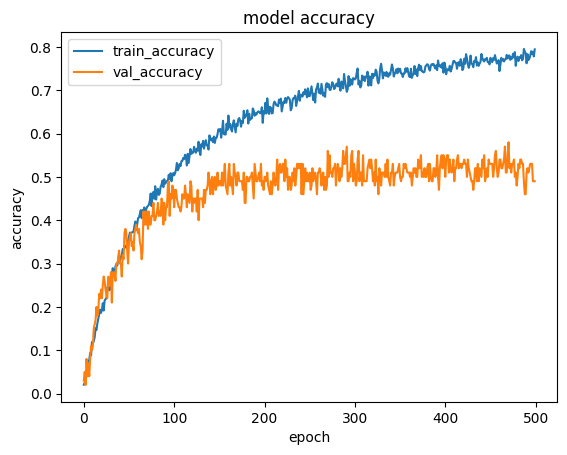

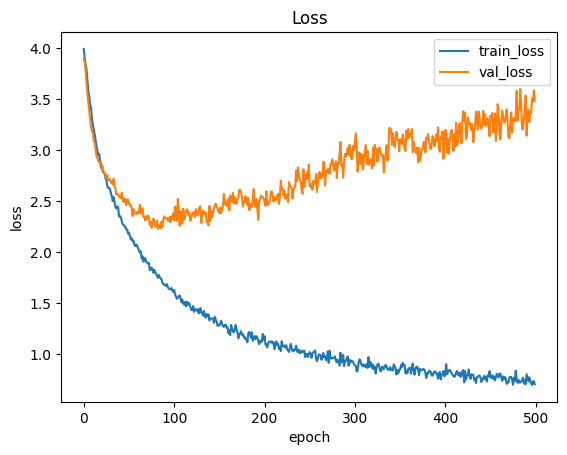

In [94]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label= 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Predicting

In [95]:
predict_x = model.predict(X_test) 
classes_x = np.argmax(predict_x,axis=1)
for i in range(len(classes_x)) :
    print(f'Predited {classes_x[i]} Target {T_test[i]}')

4/4 [==============================] - 0s 3ms/step
Predited 44 Target 9
Predited 49 Target 49
Predited 32 Target 28
Predited 34 Target 29
Predited 43 Target 43
Predited 34 Target 28
Predited 40 Target 40
Predited 30 Target 43
Predited 21 Target 2
Predited 28 Target 28
Predited 48 Target 48
Predited 2 Target 49
Predited 31 Target 15
Predited 0 Target 0
Predited 45 Target 44
Predited 45 Target 45
Predited 27 Target 17
Predited 34 Target 38
Predited 31 Target 24
Predited 38 Target 15
Predited 11 Target 11
Predited 44 Target 44
Predited 11 Target 11
Predited 34 Target 17
Predited 7 Target 35
Predited 12 Target 31
Predited 0 Target 0
Predited 1 Target 5
Predited 36 Target 36
Predited 7 Target 7
Predited 43 Target 2
Predited 41 Target 41
Predited 5 Target 5
Predited 23 Target 32
Predited 10 Target 10
Predited 47 Target 47
Predited 44 Target 44
Predited 29 Target 21
Predited 21 Target 21
Predited 12 Target 12
Predited 21 Target 43
Predited 25 Target 33
Predited 14 Target 14
Predited 21 Target